## UK Retail E-Commerce Data Analysis

#### Dataset overview
- "This is a transactional data set which contains all the transactions occurring between 12/1/2010 and 12/09/2011 for a UK-based and registered non-store online retail". Data source from https://www.kaggle.com/carrie1/ecommerce-data/downloads/ecommerce-data.zip
- The raw dataset includes over 541,000 rows across 8 columns: **InvoiceNo	StockCode	Description	Quantity	InvoiceDate	UnitPrice	CustomerID	Country**

Here is a brief look of the first 5 rows of the data

In [3]:
import pandas as pd
import matplotlib as mpl
import numpy as np
# allow multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# read data from file
df = pd.read_csv('data.csv', encoding='latin1')
# display first and last 5 rows of the data
df.head()
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [4]:
# A quick survey of the data
df.dtypes
df.describe()

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


#### What can we learn from this data set? 

- Column names are self-explanatory:
    
    **InvoiceNo:** order identification. Note: it is not a number! Alphabet characters can be encoded in the InvoiceNo
    
    **StockCode:** Item identification. Note: it is not a number either
    
    **Description:** Item name or description. 
    
    **Quantity:** item quantity in this order. It is an integer. Can be 0 and negative
    
    **InvoiceDate:** date when the order is placed, formatted as %m/%d/%Y %H:%M
    
    **UnitPrice:** price per unit for this item. It can be negative or 0
    
    **CustomerID:** customer identification
    
    **Country:** customer residence country
    

- By ananlyzing the data in details, we can extract some interesting and useful information from this dataset, such as:

    1. How many customers are shopping at the store and how are they distributed around world?
    2. How many products are sold? What are the most popular products sold?
    3. Are there any consumer shopping patterns? If there is any, how can these patterns be useful for improving the 
    4. How is the sales of each month? How can we predict the sales for the next year?

#### Since many people have done the work on consumer segmentation for this dataset, I will focus more on the sales prediction using time series model.



In [5]:
# Display different InvoiceType count and its percentage. Also display unitPrice==0 invoice count
def CountSummary():
    orderedNo = df.loc[ (df['Quantity'] > 0)].count().InvoiceNo
    canceledNo = df.loc[ (df['Quantity'] < 0) & (df['InvoiceNo'].str[:1] == 'C')].count().InvoiceNo
    returnedNo = df.loc[ (df['Quantity'] < 0) & (df['InvoiceNo'].str[:1] != 'C')].count().InvoiceNo
    totalNo = df.loc[ (df['Quantity'] != 0)].count().InvoiceNo
    
    ordered_0_unitPriceNo = df.loc[ (df['Quantity'] > 0) & (df['UnitPrice'] == 0)].count().InvoiceNo
    canceled_0_unitPricedNo = df.loc[ (df['Quantity'] < 0) & (df['InvoiceNo'].str[:1] == 'C') & (df['UnitPrice'] == 0)].count().InvoiceNo
    returned_0_unitPricedNo = df.loc[ (df['Quantity'] < 0) & (df['InvoiceNo'].str[:1] != 'C') & (df['UnitPrice'] == 0)].count().InvoiceNo
    total_0_unitPriceNo = df.loc[(df['UnitPrice'] == 0.0)].count().InvoiceNo

    d = {'Count Type': ['Ordered', 'Canceled', 'Returned', 'Total'], 
         'Invoice Count': [orderedNo, canceledNo, returnedNo, totalNo],
         'Percentage': [orderedNo/totalNo, canceledNo/totalNo, returnedNo/totalNo, totalNo/totalNo],
         'UnitPrice==0': [ordered_0_unitPriceNo,canceled_0_unitPricedNo, returned_0_unitPricedNo, total_0_unitPriceNo]
         }
    dfNo = pd.DataFrame(data=d)
    print (dfNo)
    
print ('Before fixing UnitPrice column invoice type count')
CountSummary()


Before fixing UnitPrice column invoice type count
  Count Type  Invoice Count  Percentage  UnitPrice==0
0    Ordered         531285    0.980395          1179
1   Canceled           9288    0.017139             0
2   Returned           1336    0.002465          1336
3      Total         541909    1.000000          2515


In [3]:
# This function finds the nearest unit price for the same StockCode BEFORE the current invoiceNo if its unitPrice is 0
# since returned items have no unit price and this part of the sales should not be counted
def fix_returned_unitPrice(row, df):

    idx = row.name
    stkCode = df.iloc[idx].StockCode
    unitP = df.loc[(df.index < idx) & (df['StockCode'].str[:12] == stkCode) & (df['UnitPrice'] != 0.0)].tail(1)

    if (len(unitP) == 1) :
        #print ('unitPrice found: index(0)=', unitP.index[0], 'UnitPrice=', unitP.iloc[0].UnitPrice, ', stkCode=', stkCode, ', idx=', idx)
        df.loc[df.index == idx, 'UnitPrice'] =  unitP.iloc[0].UnitPrice
    #else :
    #    print ('not found UnitPrice index=', idx, 'stkCode=', stkCode)    
            

df0 = df.loc[(df['Quantity'] < 0) & (df['InvoiceNo'].str[:1] != 'C') & (df['UnitPrice'] == 0.0)].apply(
    lambda r: fix_returned_unitPrice(r, df), axis=1
)

print ('After fixing UnitPrice column invoice type count')
CountSummary()

After fixing UnitPrice column
  Count Type  Invoice Count  Percentage  UnitPrice=0
0    Ordered         531285    0.980395         1179
1   Canceled           9288    0.017139            0
2   Returned           1336    0.002465          158
3      Total         541909    1.000000         1337


## Note:
Comparing the Returned UnitPrice=0 count before and after fixing the unit price, you can see that there are still 158 returned invoices have unit price == 0. This is because it cannot find a matched item in the earlier orders, such as the orders made before 12-9-2010. Since the sales is out of range and not counted, not counting the returned values is fine too. 

The way the returned sales is handled here may not be 100% accurate, but is acceptable.

In [6]:
# add Sales column
df['Sales']=df[['Quantity']].multiply(df['UnitPrice'], axis='index')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [7]:
# create monthly sales dataset
months = ['12/1/2010', '1/1/2011', '2/1/2011', '3/1/2011', '4/1/2011', '5/1/2011', '6/1/2011', '7/1/2011', '8/1/2011', '9/1/2011', '10/1/2011', '11/1/2011']
sales = [df.loc[(pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M').dt.month == 12), 'Sales'].sum()]

for month in range(1, 12):
    sales.append(df.loc[(pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M').dt.month == month), 'Sales'].sum())
    
df2 = pd.DataFrame( 
    {'Month': months,
     'Sales': sales
    })
df2

,Month,Sales
0,12/1/2010,1182625.030
1,1/1/2011,560000.260
2,2/1/2011,498062.650
3,3/1/2011,683267.080
4,4/1/2011,493207.121
5,5/1/2011,723333.510
6,6/1/2011,691123.120
7,7/1/2011,681300.111
8,8/1/2011,682680.510
9,9/1/2011,1019687.622


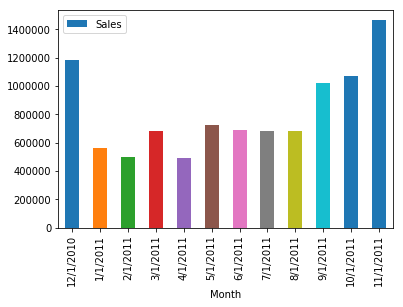

In [9]:
df2.plot(kind='bar', x=df2['Month'], y='Sales')

#### Prepare data for time series forecast

In order to use time series to forecast sales for the future months, more than one year worth of data is needed. Due to the limitation of the dataset and the purpose of this project to learn how to use time series model, I choose to generate additional data based on the existing one year worth of data. The data is generated based on two rules:
1. The sales of each month increases a fixed percentage(6%) based on the sales of same month of previous year
2. The actual sales of the month is fluctuated randomly between +/-3% on top of the value obtained from rule No.1.

Totally 6-year worth of data is saved in 'sales_extended_data.csv' file. The first 4 years' data will be used for training the model and the other two years will be used for cross validation.

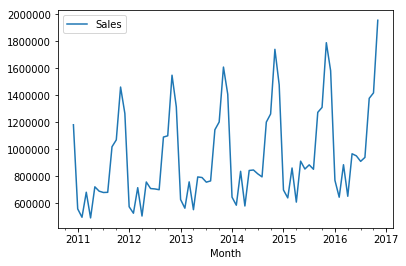

In [43]:
from datetime import datetime
import random

# create 6 more years of index label
date_index = [datetime(2010,12,1)]

YEARS = 6
MONTHS = 12
monthOverMonthIncRate = 1.06
fluctRange = 3

for i in range(1, YEARS+1) :     
    for j in range(1, MONTHS+1) :
        date_index.append(datetime(2010 + i, j%MONTHS if j%12 != 0 else 12, 1))
del date_index[-1]  # delete last item

sales_data = []
for i in range(1, YEARS+1) :     
    for j in range(1, MONTHS+1) :
        v = sales[j-1]*pow(monthOverMonthIncRate, i-1)   # linear increment over last year's same month
        if i > 1:
            v = v * (random.randint(-fluctRange, fluctRange)/100.0 + 1)  # add 3% fluctuation
        sales_data.append(v)

ts = pd.DataFrame( 
    {'Month': date_index,
     'Sales': sales_data
    })

# don't write index label
ts.to_csv("sales_extended_data.csv",  float_format='%.2f', index=False )

ts.plot(kind='line', x=ts['Month'], y='Sales')